# Example 1: Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistrated functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

For every subject we have one anatomical T1w and 5 functional images. As a short recap, the image properties of the anatomy and the **fingerfootlips** functional image are:

In [1]:
%%bash
cd /data/ds000114/sub-01/ses-test
nib-ls a*/*.nii.gz f*/*fingerfootlips*.nii.gz

anat/sub-01_ses-test_T1w.nii.gz                      float32 [256, 156, 256]      1.00x1.30x1.00        sform
func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz  int16  [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50   sform



**So, let's start!**

## Imports

First, let's import all modules we later will be needing.

In [20]:
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. We will use one functional image for fingerfootlips task for ten subjects.

In [21]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05',
                'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [22]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1),
               output_type='NIFTI',
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

## Coregistration Workflow

Initiate a workflow that coregistrates the functional images to the anatomical image (according to FSL's FEAT pipeline).

In [23]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [24]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', '{subject_id}', 'anat', '{subject_id}_t1w_preproc.nii.gz')
func_file = opj('{subject_id}', 'ses-test', 'func',
                '{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [25]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

171025-18:59:48,8 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=colored, simple_form=True).


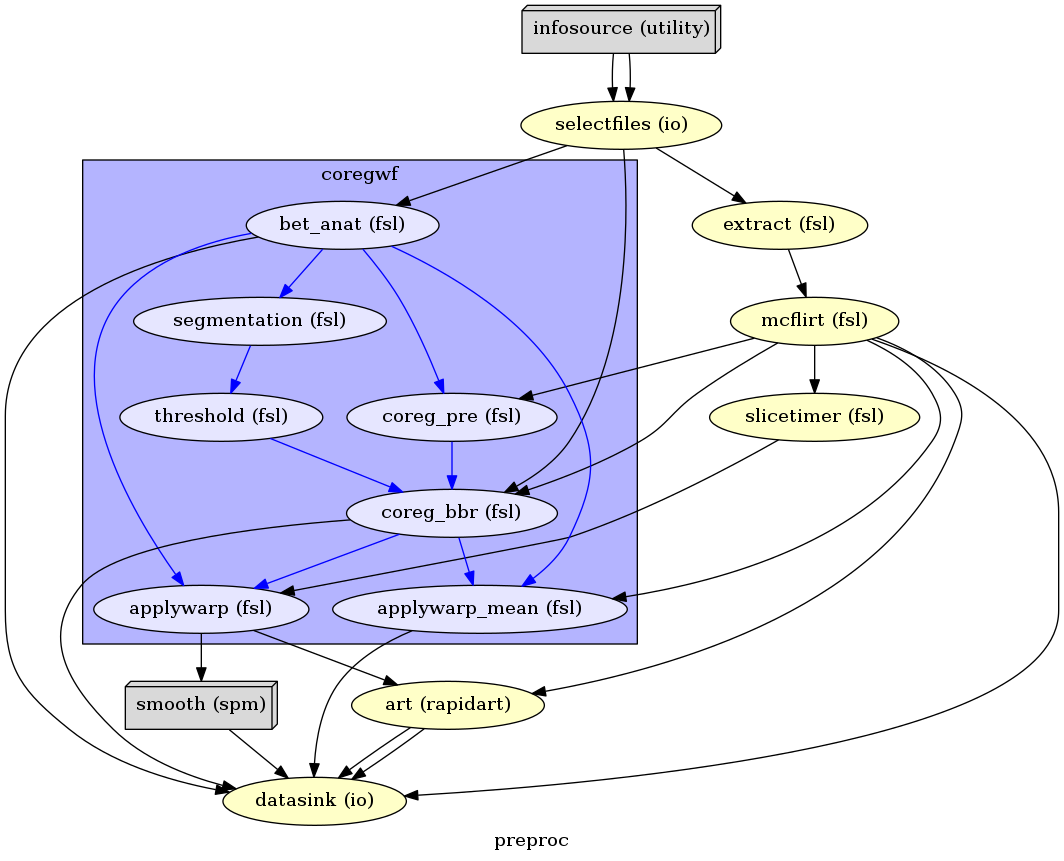

In [27]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.dot.png'))

171009-18:15:09,595 workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.dot.png (graph2use=flat, simple_form=True).


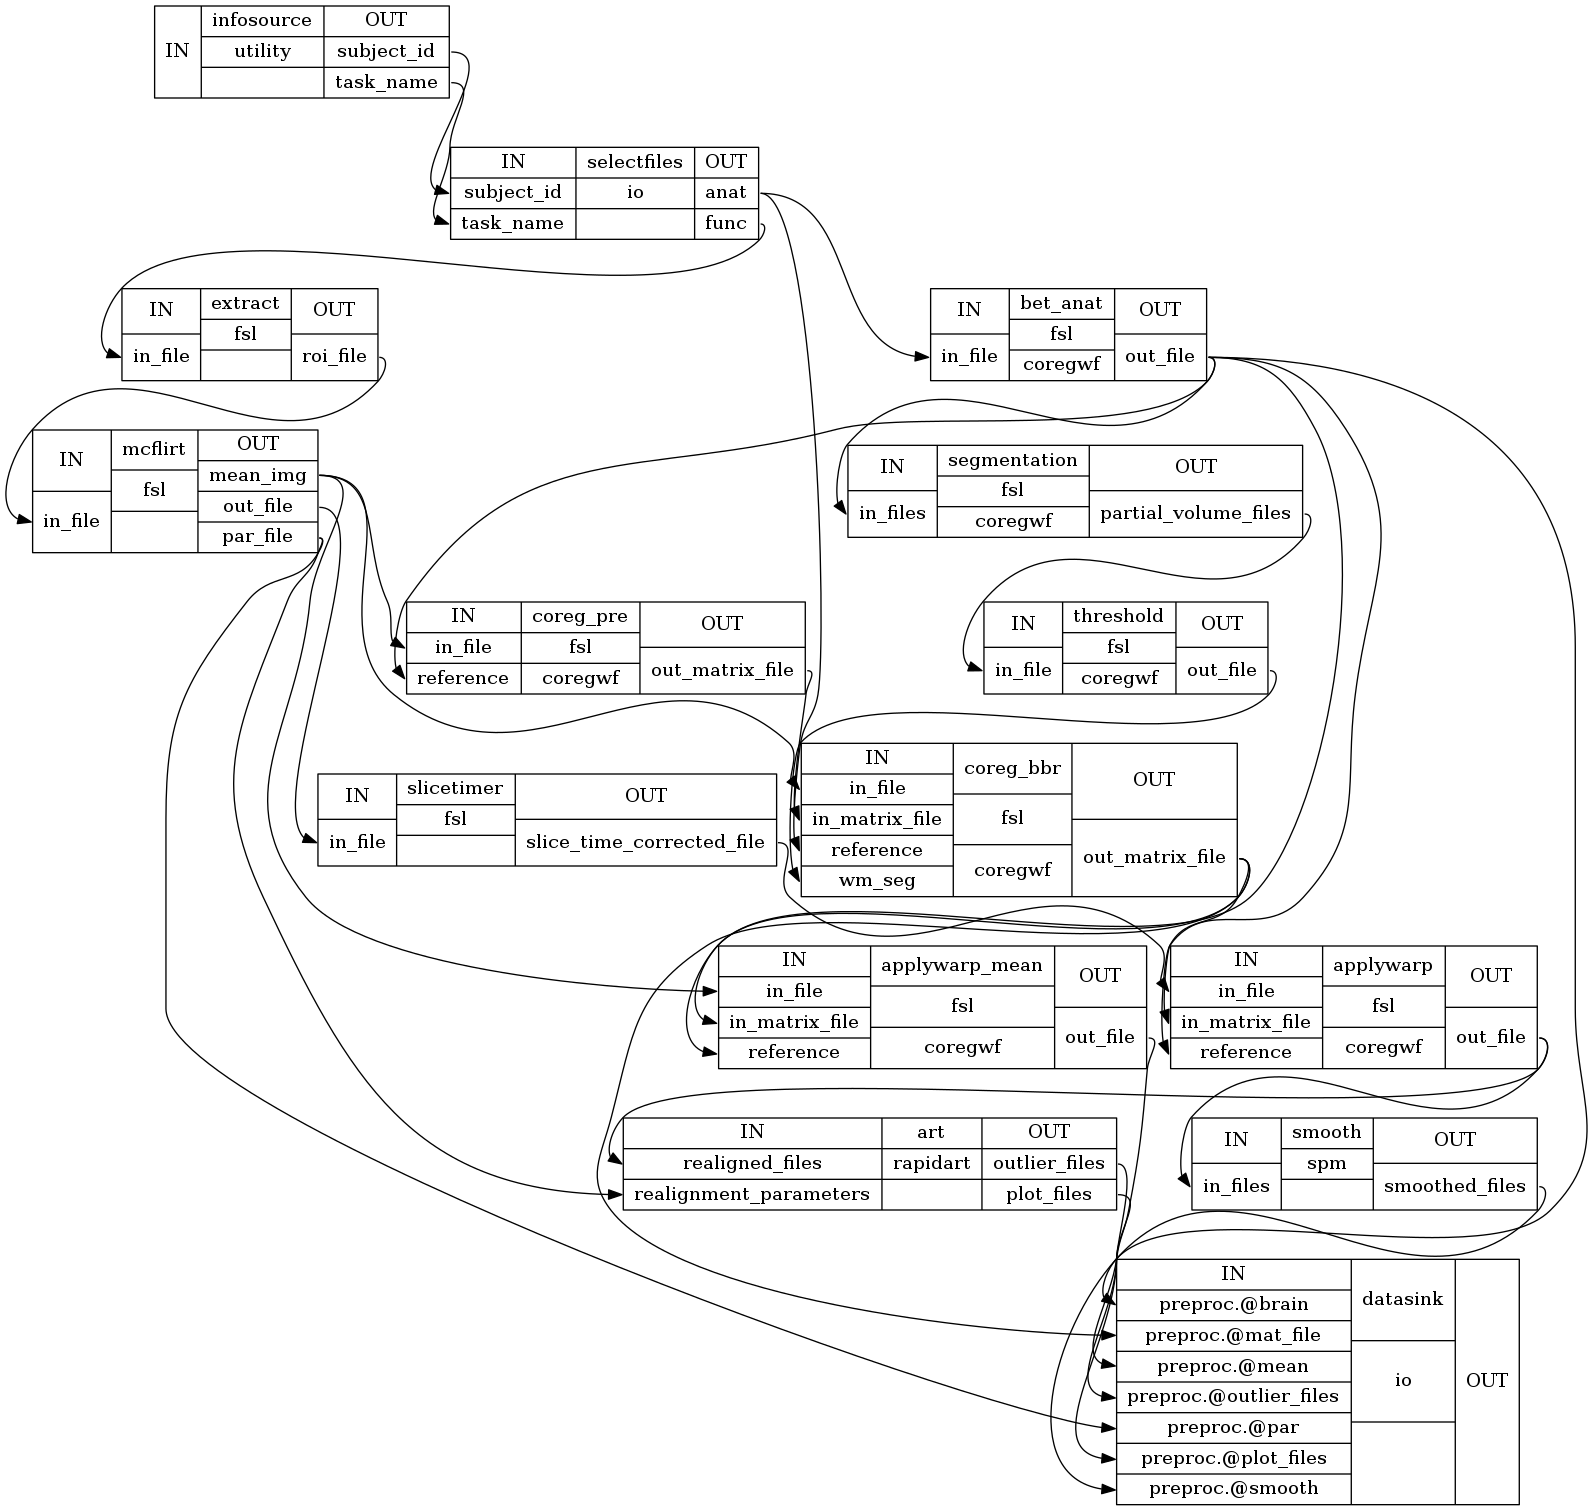

In [9]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [10]:
preproc.run('MultiProc', plugin_args={'n_procs': 6})

171009-18:15:20,328 workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging']
171009-18:15:20,486 workflow INFO:
	 Running in parallel.
171009-18:15:20,497 workflow INFO:
	 Executing: selectfiles.b9 ID: 0
171009-18:15:20,506 workflow INFO:
	 Executing: selectfiles.b8 ID: 16
171009-18:15:20,510 workflow INFO:
	 Executing node selectfiles.b9 in dir: /output/workingdir/preproc/_subject_id_sub-10_task_name_fingerfootlips/selectfiles
171009-18:15:20,524 workflow INFO:
	 Executing: selectfiles.b7 ID: 32
171009-18:15:20,530 workflow INFO:
	 Executing node selectfiles.b8 in dir: /output/workingdir/preproc/_subject_id_sub-09_task_name_fingerfootlips/selectfiles
171009-18:15:20,539 workflow INFO:
	 Executing: selectfiles.b6 ID: 48
171009-18:15:20,545 workflow INFO:
	 Executing node selectfiles.b7 in dir: /output/workingdir/preproc/_subject_id_sub-08_task_name_fingerfootlips/selectfiles
171009-18:15:20,556 workflow INFO:
	 Executing: selectfiles.b5 ID: 64
171009-18:15:20,562 w

171009-18:15:41,649 workflow INFO:
	 [Job finished] jobname: slicetimer.b4 jobid: 83
171009-18:15:43,658 workflow INFO:
	 Executing: bet_anat.b4 ID: 84
171009-18:15:43,688 workflow INFO:
	 [Job finished] jobname: bet_anat.b4 jobid: 84
171009-18:15:45,698 workflow INFO:
	 Executing: segmentation.b4 ID: 85
171009-18:15:45,736 workflow INFO:
	 Executing node segmentation.b4 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-05_task_name_fingerfootlips/segmentation
171009-18:15:45,832 workflow INFO:
	 Running: fast -S 1 /output/workingdir/preproc/coregwf/_subject_id_sub-05_task_name_fingerfootlips/segmentation/sub-05_t1w_preproc_brain.nii.gz
171009-18:21:18,738 workflow INFO:
	 [Job finished] jobname: segmentation.b9 jobid: 5
171009-18:21:18,743 workflow INFO:
	 Executing: threshold.b9 ID: 6
171009-18:21:18,757 workflow INFO:
	 Executing node threshold.b9 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-10_task_name_fingerfootlips/threshold
171009-18:21:18,873 workflow IN

	 Running: fslmaths /output/workingdir/preproc/coregwf/_subject_id_sub-08_task_name_fingerfootlips/segmentation/sub-08_t1w_preproc_brain_pve_2.nii.gz -thr 0.5000000000 -bin /output/workingdir/preproc/coregwf/_subject_id_sub-08_task_name_fingerfootlips/threshold/sub-08_t1w_preproc_brain_pve_2_thresh.nii.gz
171009-18:21:47,705 workflow INFO:
	 [Job finished] jobname: threshold.b7 jobid: 38
171009-18:21:47,709 workflow INFO:
	 Executing: coreg_bbr.b7 ID: 40
171009-18:21:47,741 workflow INFO:
	 Executing node coreg_bbr.b7 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-08_task_name_fingerfootlips/coreg_bbr
171009-18:21:47,818 workflow INFO:
	 Running: flirt -in /output/workingdir/preproc/_subject_id_sub-08_task_name_fingerfootlips/mcflirt/sub-08_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_preproc.nii.gz -out sub-08_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-08_ses-te

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


171009-18:24:47,495 workflow INFO:
	 [Job finished] jobname: art.b5 jobid: 74
171009-18:24:47,505 workflow INFO:
	 Executing: applywarp_mean.b6 ID: 61
171009-18:24:47,537 workflow INFO:
	 Executing node applywarp_mean.b6 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-07_task_name_fingerfootlips/applywarp_mean
171009-18:24:47,553 workflow INFO:
	 [Job finished] jobname: coreg_bbr.b9 jobid: 8
171009-18:24:47,561 workflow INFO:
	 Executing: applywarp.b9 ID: 9
171009-18:24:47,577 workflow INFO:
	 Running: flirt -in /output/workingdir/preproc/_subject_id_sub-07_task_name_fingerfootlips/mcflirt/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /output/workingdir/preproc/coregwf/_subject_id_sub-07_task_name_fingerfootlips/bet_anat/sub-07_t1w_preproc_brain.nii.gz -out sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -applyisoxfm 4.000000 -init /output/working

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


171009-18:25:06,711 workflow INFO:
	 [Job finished] jobname: art.b6 jobid: 58
171009-18:25:06,717 workflow INFO:
	 Executing: smooth.aI.a0.b9 ID: 11
171009-18:25:06,740 workflow INFO:
	 Executing node smooth.aI.a0.b9 in dir: /output/workingdir/preproc/_subject_id_sub-10_task_name_fingerfootlips/_fwhm_4/smooth


/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


171009-18:25:09,609 workflow INFO:
	 [Job finished] jobname: art.b9 jobid: 10
171009-18:25:09,615 workflow INFO:
	 Executing: smooth.aI.a1.b9 ID: 12
171009-18:25:09,632 workflow INFO:
	 Executing node smooth.aI.a1.b9 in dir: /output/workingdir/preproc/_subject_id_sub-10_task_name_fingerfootlips/_fwhm_8/smooth
171009-18:25:27,428 workflow INFO:
	 [Job finished] jobname: coreg_bbr.b4 jobid: 88
171009-18:25:27,435 workflow INFO:
	 Executing: smooth.aI.a0.b6 ID: 59
171009-18:25:27,455 workflow INFO:
	 Executing node smooth.aI.a0.b6 in dir: /output/workingdir/preproc/_subject_id_sub-07_task_name_fingerfootlips/_fwhm_4/smooth
171009-18:25:30,189 workflow INFO:
	 [Job finished] jobname: coreg_bbr.b8 jobid: 24
171009-18:25:30,198 workflow INFO:
	 Executing: applywarp.b8 ID: 25
171009-18:25:30,232 workflow INFO:
	 Executing node applywarp.b8 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-09_task_name_fingerfootlips/applywarp
171009-18:25:30,278 workflow INFO:
	 Running: flirt -in /o

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


171009-18:25:53,776 workflow INFO:
	 [Job finished] jobname: art.b8 jobid: 26
171009-18:25:53,781 workflow INFO:
	 Executing: smooth.aI.a0.b8 ID: 27
171009-18:25:53,815 workflow INFO:
	 Executing node smooth.aI.a0.b8 in dir: /output/workingdir/preproc/_subject_id_sub-09_task_name_fingerfootlips/_fwhm_4/smooth
171009-18:25:54,243 workflow INFO:
	 [Job finished] jobname: applywarp.b7 jobid: 41
171009-18:25:54,252 workflow INFO:
	 Executing: smooth.aI.a1.b8 ID: 28
171009-18:25:54,277 workflow INFO:
	 Executing node smooth.aI.a1.b8 in dir: /output/workingdir/preproc/_subject_id_sub-09_task_name_fingerfootlips/_fwhm_8/smooth
171009-18:27:25,147 workflow INFO:
	 [Job finished] jobname: smooth.aI.a0.b5 jobid: 75
171009-18:27:25,152 workflow INFO:
	 Executing: art.b7 ID: 42
171009-18:27:25,188 workflow INFO:
	 Executing node art.b7 in dir: /output/workingdir/preproc/_subject_id_sub-08_task_name_fingerfootlips/art
171009-18:27:25,285 interface INFO:
	 not intersect_mask is True
171009-18:27:32,

	 sub: /output/datasink/preproc/_subject_id_sub-07_task_name_fingerfootlips/art.sub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-07/task-fingerfootlips/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt
171009-18:27:58,270 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-07_task_name_fingerfootlips/plot.sub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-07/task-fingerfootlips/plot.sub-07_ses-test_task-fingerfootlips_bold.svg
171009-18:27:58,282 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-07_task_name_fingerfootlips/_fwhm_4/ssub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.nii -> /output/datasink/preproc/sub-07/task-fingerfootlips/fwhm-4_ssub-07_ses-test_task-fingerfootlips_bold.nii
171009-18:27:58,295 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-07_task_name_fingerfootlips/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.

	 sub: /output/datasink/preproc/_subject_id_sub-09_task_name_fingerfootlips/sub-09_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-09/task-fingerfootlips/sub-09_ses-test_task-fingerfootlips_bold.par
171009-18:28:30,76 workflow INFO:
	 Executing node applywarp.b4 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-05_task_name_fingerfootlips/applywarp
171009-18:28:30,80 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-09_task_name_fingerfootlips/art.sub-09_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-09/task-fingerfootlips/art.sub-09_ses-test_task-fingerfootlips_bold_outliers.txt
171009-18:28:30,134 workflow INFO:
	 Running: flirt -in /output/workingdir/preproc/_subject_id_sub-05_task_name_fingerfootlips/slicetimer/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf_st.nii -ref /output/workingdir/preproc/coregwf/_subject_id_sub-05_task_name_fingerfootlips/bet_anat/sub-05_t1w_preproc_b

171009-18:30:11,584 workflow INFO:
	 Executing: smooth.aI.a1.b4 ID: 92
171009-18:30:11,612 workflow INFO:
	 Executing node smooth.aI.a1.b4 in dir: /output/workingdir/preproc/_subject_id_sub-05_task_name_fingerfootlips/_fwhm_8/smooth
171009-18:30:20,169 workflow INFO:
	 [Job finished] jobname: smooth.aI.a1.b7 jobid: 44
171009-18:30:20,177 workflow INFO:
	 Executing: datasink.a1.b7 ID: 47
171009-18:30:20,262 workflow INFO:
	 Executing node datasink.a1.b7 in dir: /output/workingdir/preproc/_subject_id_sub-08_task_name_fingerfootlips/_fwhm_8/datasink
171009-18:30:20,325 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-08_task_name_fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-08/task-fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold.par
171009-18:30:20,337 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-08_task_name_fingerfootlips/art.sub-08_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outl

	 Executing node datasink.a1.b5 in dir: /output/workingdir/preproc/_subject_id_sub-06_task_name_fingerfootlips/_fwhm_8/datasink
171009-18:30:39,609 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-06_task_name_fingerfootlips/sub-06_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-06/task-fingerfootlips/sub-06_ses-test_task-fingerfootlips_bold.par
171009-18:30:39,620 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-06_task_name_fingerfootlips/art.sub-06_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-06/task-fingerfootlips/art.sub-06_ses-test_task-fingerfootlips_bold_outliers.txt
171009-18:30:39,629 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-06_task_name_fingerfootlips/plot.sub-06_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-06/task-fingerfootlips/plot.sub-06_ses-test_task-fingerfootlips_bold.svg
171009-18:30:39,639

	 sub: /output/datasink/preproc/_subject_id_sub-05_task_name_fingerfootlips/_fwhm_8/ssub-05_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.nii -> /output/datasink/preproc/sub-05/task-fingerfootlips/fwhm-8_ssub-05_ses-test_task-fingerfootlips_bold.nii
171009-18:32:29,913 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-05_task_name_fingerfootlips/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -> /output/datasink/preproc/sub-05/task-fingerfootlips/sub-05_ses-test_task-fingerfootlips_bold_mean.mat
171009-18:32:29,923 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-05_task_name_fingerfootlips/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -> /output/datasink/preproc/sub-05/task-fingerfootlips/sub-05_ses-test_task-fingerfootlips_bold_mean.nii.gz
171009-18:32:29,938 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-05_task_name_fingerfootlips/sub-05_t1w_preproc_brain.nii.gz -> /output/datasi

	 Running: fslmaths /output/workingdir/preproc/coregwf/_subject_id_sub-03_task_name_fingerfootlips/segmentation/sub-03_t1w_preproc_brain_pve_2.nii.gz -thr 0.5000000000 -bin /output/workingdir/preproc/coregwf/_subject_id_sub-03_task_name_fingerfootlips/threshold/sub-03_t1w_preproc_brain_pve_2_thresh.nii.gz
171009-18:35:37,927 workflow INFO:
	 [Job finished] jobname: threshold.b2 jobid: 118
171009-18:35:37,931 workflow INFO:
	 Executing: coreg_bbr.b2 ID: 120
171009-18:35:37,968 workflow INFO:
	 Executing node coreg_bbr.b2 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-03_task_name_fingerfootlips/coreg_bbr
171009-18:35:38,2 workflow INFO:
	 Running: flirt -in /output/workingdir/preproc/_subject_id_sub-03_task_name_fingerfootlips/mcflirt/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_preproc.nii.gz -out sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-03_ses-te

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


171009-18:36:34,745 workflow INFO:
	 [Job finished] jobname: art.b3 jobid: 106
171009-18:37:14,537 workflow INFO:
	 [Job finished] jobname: segmentation.b1 jobid: 133
171009-18:37:14,542 workflow INFO:
	 Executing: threshold.b1 ID: 134
171009-18:37:14,557 workflow INFO:
	 Executing node threshold.b1 in dir: /output/workingdir/preproc/coregwf/_subject_id_sub-02_task_name_fingerfootlips/threshold
171009-18:37:14,585 workflow INFO:
	 Running: fslmaths /output/workingdir/preproc/coregwf/_subject_id_sub-02_task_name_fingerfootlips/segmentation/sub-02_t1w_preproc_brain_pve_2.nii.gz -thr 0.5000000000 -bin /output/workingdir/preproc/coregwf/_subject_id_sub-02_task_name_fingerfootlips/threshold/sub-02_t1w_preproc_brain_pve_2_thresh.nii.gz
171009-18:37:16,9 workflow INFO:
	 [Job finished] jobname: threshold.b1 jobid: 134
171009-18:37:16,15 workflow INFO:
	 Executing: coreg_bbr.b1 ID: 136
171009-18:37:16,54 workflow INFO:
	 Executing node coreg_bbr.b1 in dir: /output/workingdir/preproc/coregwf/_s

	 Running: flirt -in /output/workingdir/preproc/_subject_id_sub-03_task_name_fingerfootlips/mcflirt/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /output/workingdir/preproc/coregwf/_subject_id_sub-03_task_name_fingerfootlips/bet_anat/sub-03_t1w_preproc_brain.nii.gz -out sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -applyisoxfm 4.000000 -init /output/workingdir/preproc/coregwf/_subject_id_sub-03_task_name_fingerfootlips/coreg_bbr/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -interp spline
171009-18:39:19,203 workflow INFO:
	 [Job finished] jobname: applywarp_mean.b2 jobid: 125
171009-18:39:28,105 workflow INFO:
	 [Job finished] jobname: applywarp.b2 jobid: 121
171009-18:39:28,109 workflow INFO:
	 Executing: art.b2 ID: 122
171009-18:39:28,124 workflow INFO:
	 Executing: smooth.aI.a0.b2 ID: 123
171009-18:39:28,126 workflow INFO:
	 

	 sub: /output/datasink/preproc/_subject_id_sub-03_task_name_fingerfootlips/_fwhm_4/ssub-03_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.nii -> /output/datasink/preproc/sub-03/task-fingerfootlips/fwhm-4_ssub-03_ses-test_task-fingerfootlips_bold.nii
171009-18:41:05,494 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-03_task_name_fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -> /output/datasink/preproc/sub-03/task-fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_mean.mat
171009-18:41:05,499 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-03_task_name_fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -> /output/datasink/preproc/sub-03/task-fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_mean.nii.gz
171009-18:41:05,506 interface INFO:
	 sub: /output/datasink/preproc/_subject_id_sub-03_task_name_fingerfootlips/sub-03_t1w_preproc_brain.nii.gz -> /output/datasi

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [28]:
!tree /output/datasink

/output/datasink
|-- 1stLevel
|   |-- sub-01
|   |   |-- fwhm-4
|   |   |   |-- SPM.mat
|   |   |   |-- con_0001.nii
|   |   |   |-- con_0002.nii
|   |   |   |-- con_0003.nii
|   |   |   |-- con_0004.nii
|   |   |   |-- con_0005.nii
|   |   |   |-- con_0006.nii
|   |   |   |-- con_0007.nii
|   |   |   |-- ess_0008.nii
|   |   |   |-- ess_0009.nii
|   |   |   |-- spmF_0008.nii
|   |   |   |-- spmF_0009.nii
|   |   |   |-- spmT_0001.nii
|   |   |   |-- spmT_0002.nii
|   |   |   |-- spmT_0003.nii
|   |   |   |-- spmT_0004.nii
|   |   |   |-- spmT_0005.nii
|   |   |   |-- spmT_0006.nii
|   |   |   `-- spmT_0007.nii
|   |   `-- fwhm-8
|   |       |-- SPM.mat
|   |       |-- con_0001.nii
|   |       |-- con_0002.nii
|   |       |-- con_0003.nii
|   |       |-- con_0004.nii
|   |       |-- con_0005.nii
|   |       |-- con_0006.nii
|   |       |-- con_0007.nii
|   |       |-- ess_0008.nii
|   |       |-- ess_0009.nii
|   |       |-- spmF_0008.nii
|   |       |-- spmF_0009.nii
|   |       |-- s

|   |   |-- fwhm-4
|   |   |   |-- SPM.mat
|   |   |   |-- con_0001.nii
|   |   |   |-- con_0002.nii
|   |   |   |-- con_0003.nii
|   |   |   |-- con_0004.nii
|   |   |   |-- con_0005.nii
|   |   |   |-- con_0006.nii
|   |   |   |-- con_0007.nii
|   |   |   |-- ess_0008.nii
|   |   |   |-- ess_0009.nii
|   |   |   |-- spmF_0008.nii
|   |   |   |-- spmF_0009.nii
|   |   |   |-- spmT_0001.nii
|   |   |   |-- spmT_0002.nii
|   |   |   |-- spmT_0003.nii
|   |   |   |-- spmT_0004.nii
|   |   |   |-- spmT_0005.nii
|   |   |   |-- spmT_0006.nii
|   |   |   `-- spmT_0007.nii
|   |   `-- fwhm-8
|   |       |-- SPM.mat
|   |       |-- con_0001.nii
|   |       |-- con_0002.nii
|   |       |-- con_0003.nii
|   |       |-- con_0004.nii
|   |       |-- con_0005.nii
|   |       |-- con_0006.nii
|   |       |-- con_0007.nii
|   |       |-- ess_0008.nii
|   |       |-- ess_0009.nii
|   |       |-- spmF_0008.nii
|   |       |-- spmF_0009.nii
|   |       |-- spmT_0001.nii
|   |       |-- spmT_0002.nii
| 

|   |-- sub-07_fwhm8
|   |   |-- con_0001_trans.nii
|   |   |-- con_0002_trans.nii
|   |   |-- con_0003_trans.nii
|   |   |-- con_0004_trans.nii
|   |   |-- con_0005_trans.nii
|   |   |-- con_0006_trans.nii
|   |   |-- con_0007_trans.nii
|   |   |-- ess_0008_trans.nii
|   |   `-- ess_0009_trans.nii
|   |-- sub-08_fwhm4
|   |   |-- con_0001_trans.nii
|   |   |-- con_0002_trans.nii
|   |   |-- con_0003_trans.nii
|   |   |-- con_0004_trans.nii
|   |   |-- con_0005_trans.nii
|   |   |-- con_0006_trans.nii
|   |   |-- con_0007_trans.nii
|   |   |-- ess_0008_trans.nii
|   |   `-- ess_0009_trans.nii
|   |-- sub-08_fwhm8
|   |   |-- con_0001_trans.nii
|   |   |-- con_0002_trans.nii
|   |   |-- con_0003_trans.nii
|   |   |-- con_0004_trans.nii
|   |   |-- con_0005_trans.nii
|   |   |-- con_0006_trans.nii
|   |   |-- con_0007_trans.nii
|   |   |-- ess_0008_trans.nii
|   |   `-- ess_0009_trans.nii
|   |-- sub-09_fwhm4
|   |   |-- con_0001_trans.nii
|   |   |-- con_0002_trans.nii
|   |   |-- con_0

        `-- task-fingerfootlips
            |-- art.sub-10_ses-test_task-fingerfootlips_bold_outliers.txt
            |-- fwhm-4_ssub-10_ses-test_task-fingerfootlips_bold.nii
            |-- fwhm-8_ssub-10_ses-test_task-fingerfootlips_bold.nii
            |-- plot.sub-10_ses-test_task-fingerfootlips_bold.svg
            |-- sub-10_ses-test_task-fingerfootlips_bold.par
            |-- sub-10_ses-test_task-fingerfootlips_bold_mean.mat
            |-- sub-10_ses-test_task-fingerfootlips_bold_mean.nii.gz
            `-- sub-10_t1w_preproc_brain.nii.gz

111 directories, 838 files


In [11]:
!tree /output/datasink/preproc

/output/datasink/preproc
|-- sub-01
|   `-- task-fingerfootlips
|       |-- art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt
|       |-- fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii
|       |-- fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii
|       |-- plot.sub-01_ses-test_task-fingerfootlips_bold.svg
|       |-- sub-01_ses-test_task-fingerfootlips_bold.par
|       |-- sub-01_ses-test_task-fingerfootlips_bold_mean.mat
|       |-- sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz
|       `-- sub-01_t1w_preproc_brain.nii.gz
|-- sub-02
|   `-- task-fingerfootlips
|       |-- art.sub-02_ses-test_task-fingerfootlips_bold_outliers.txt
|       |-- fwhm-4_ssub-02_ses-test_task-fingerfootlips_bold.nii
|       |-- fwhm-8_ssub-02_ses-test_task-fingerfootlips_bold.nii
|       |-- plot.sub-02_ses-test_task-fingerfootlips_bold.svg
|       |-- sub-02_ses-test_task-fingerfootlips_bold.par
|       |-- sub-02_ses-test_task-fingerfootlips_bold_mean.mat
|       |-- sub-02_ses-tes

In [30]:
!tree /data/ds000114/derivatives

/data/ds000114/derivatives
|-- fmriprep
|   |-- mni_icbm152_nlin_asym_09c
|   |   |-- 1mm_PD.nii.gz
|   |   |-- 1mm_PD_orig.nii.gz
|   |   |-- 1mm_T1.nii.gz
|   |   |-- 1mm_T1_orig.nii.gz
|   |   |-- 1mm_T2.nii.gz
|   |   |-- 1mm_T2_orig.nii.gz
|   |   |-- 1mm_brainmask.nii.gz
|   |   |-- 1mm_eyemask.nii.gz
|   |   |-- 1mm_facemask.nii.gz
|   |   |-- 1mm_headmask.nii.gz
|   |   |-- 1mm_parc.nii.gz
|   |   |-- 1mm_tpm_csf.nii.gz
|   |   |-- 1mm_tpm_gm.nii.gz
|   |   |-- 1mm_tpm_wm.nii.gz
|   |   |-- 2mm_PD.nii.gz
|   |   |-- 2mm_T1.nii.gz
|   |   |-- 2mm_T2.nii.gz
|   |   |-- 2mm_brainmask.nii.gz
|   |   |-- 2mm_eyemask.nii.gz
|   |   |-- 2mm_facemask.nii.gz
|   |   |-- 2mm_headmask.nii.gz
|   |   |-- 2mm_parc.nii.gz
|   |   |-- 2mm_tpm_csf.nii.gz
|   |   |-- 2mm_tpm_gm.nii.gz
|   |   |-- 2mm_tpm_wm.nii.gz
|   |   `-- scripts
|   |       |-- headmask.py
|   |       |-- normtpms.py
|   |       `-- parcellation.py
|   |-- sub-01
|   |   |-- anat
|   |   |   |-- sub-01_t1w_brainmask.nii.gz

|   |       `-- func
|   |           |-- sub-01_ses-test_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/VZ/1P/MD5E-s60415--9c25ed297660650de19cfd7d79e4b147.tsv/MD5E-s60415--9c25ed297660650de19cfd7d79e4b147.tsv
|   |           |-- sub-01_ses-test_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/33/mf/MD5E-s7642522--1d2f97ac7d8788ad7ee885e22965b126.func.gii/MD5E-s7642522--1d2f97ac7d8788ad7ee885e22965b126.func.gii
|   |           |-- sub-01_ses-test_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/g2/P3/MD5E-s7648467--7746c55753350526109bf12c59755db5.func.gii/MD5E-s7648467--7746c55753350526109bf12c59755db5.func.gii
|   |           |-- sub-01_ses-test_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/GK/Kj/MD5E-s4273--4aeaf5524dd061acbf00e2d5f60d1c1c.nii.gz/MD5E-s4273--4aeaf5524dd061acbf00e2d5f60d1c1c.nii.gz
|   |           |-

|   |   |   `-- func
|   |   |       |-- sub-02_ses-retest_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/4Z/Pf/MD5E-s60181--e00ed6e2ad919413d76c06280b4bdc9e.tsv/MD5E-s60181--e00ed6e2ad919413d76c06280b4bdc9e.tsv
|   |   |       |-- sub-02_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/m2/Mf/MD5E-s7650738--e115a558d2354c1f5504162ab9847742.func.gii/MD5E-s7650738--e115a558d2354c1f5504162ab9847742.func.gii
|   |   |       |-- sub-02_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/XJ/Xk/MD5E-s7672879--5c167a304db41fd9c14082ffb3419fdf.func.gii/MD5E-s7672879--5c167a304db41fd9c14082ffb3419fdf.func.gii
|   |   |       |-- sub-02_ses-retest_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/qg/m5/MD5E-s4012--c188c8dcd4dd86d50bf467c4d89c6a90.nii.gz/MD5E-s4012--c188c8dcd4dd86d50bf467c4d89c6a90.nii.gz
|   |   | 

|   |   |-- anat
|   |   |   |-- sub-03_t1w_brainmask.nii.gz -> ../../.git/annex/objects/f5/80/MD5E-s96180--a72f4b6bbdf55ae46cfabf454cd5af77.nii.gz/MD5E-s96180--a72f4b6bbdf55ae46cfabf454cd5af77.nii.gz
|   |   |   |-- sub-03_t1w_class-csf_probtissue.nii.gz -> ../../.git/annex/objects/g1/47/MD5E-s3418951--f0d706f6bb98b64f0d7ac9fb076cc9b1.nii.gz/MD5E-s3418951--f0d706f6bb98b64f0d7ac9fb076cc9b1.nii.gz
|   |   |   |-- sub-03_t1w_class-gm_probtissue.nii.gz -> ../../.git/annex/objects/mx/V1/MD5E-s3751242--e657925732f205db7d50ac577a9bbcf0.nii.gz/MD5E-s3751242--e657925732f205db7d50ac577a9bbcf0.nii.gz
|   |   |   |-- sub-03_t1w_class-wm_probtissue.nii.gz -> ../../.git/annex/objects/F5/GK/MD5E-s3275016--31a15ee1aa257b6630300298eeb31d33.nii.gz/MD5E-s3275016--31a15ee1aa257b6630300298eeb31d33.nii.gz
|   |   |   |-- sub-03_t1w_dtissue.nii.gz -> ../../.git/annex/objects/gM/4F/MD5E-s250265--304c4a8d37ab276495599c1a530a1bc5.nii.gz/MD5E-s250265--304c4a8d37ab276495599c1a530a1bc5.nii.gz
|   |   |   |-- sub-

|   |       `-- func
|   |           |-- sub-03_ses-test_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/6v/80/MD5E-s60986--1874ec0fe935d8200ddf5a499c5d6b2c.tsv/MD5E-s60986--1874ec0fe935d8200ddf5a499c5d6b2c.tsv
|   |           |-- sub-03_ses-test_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/Kg/7x/MD5E-s7699906--b10fa88863f9fa65203f159f33e13e90.func.gii/MD5E-s7699906--b10fa88863f9fa65203f159f33e13e90.func.gii
|   |           |-- sub-03_ses-test_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/vQ/K7/MD5E-s7654899--e161a362786978ed3ee1e4125e6a3074.func.gii/MD5E-s7654899--e161a362786978ed3ee1e4125e6a3074.func.gii
|   |           |-- sub-03_ses-test_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/8Q/j4/MD5E-s4188--5583be7b8c3124378a5b57431ca7e729.nii.gz/MD5E-s4188--5583be7b8c3124378a5b57431ca7e729.nii.gz
|   |           |-

|   |   |   `-- func
|   |   |       |-- sub-04_ses-retest_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/Z1/23/MD5E-s60071--c11d7a394c37370653889a2399be8b7a.tsv/MD5E-s60071--c11d7a394c37370653889a2399be8b7a.tsv
|   |   |       |-- sub-04_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/vv/8X/MD5E-s7706502--c0c0e8f07aaa4f5f11cc5f52fd36d593.func.gii/MD5E-s7706502--c0c0e8f07aaa4f5f11cc5f52fd36d593.func.gii
|   |   |       |-- sub-04_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/q9/P9/MD5E-s7672399--9d59926126f115eba92fb82740f1d06a.func.gii/MD5E-s7672399--9d59926126f115eba92fb82740f1d06a.func.gii
|   |   |       |-- sub-04_ses-retest_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/P3/8z/MD5E-s4122--e328f18ccdc574d4263fb98e74207267.nii.gz/MD5E-s4122--e328f18ccdc574d4263fb98e74207267.nii.gz
|   |   | 

|   |   |-- anat
|   |   |   |-- sub-05_t1w_brainmask.nii.gz -> ../../.git/annex/objects/j6/MP/MD5E-s110064--1a4d04d32f48a3571660242c2d90d225.nii.gz/MD5E-s110064--1a4d04d32f48a3571660242c2d90d225.nii.gz
|   |   |   |-- sub-05_t1w_class-csf_probtissue.nii.gz -> ../../.git/annex/objects/j1/gk/MD5E-s4334738--e07ef140b998c47487e7717eb76ba940.nii.gz/MD5E-s4334738--e07ef140b998c47487e7717eb76ba940.nii.gz
|   |   |   |-- sub-05_t1w_class-gm_probtissue.nii.gz -> ../../.git/annex/objects/0K/gG/MD5E-s4894771--5c2379772317f78ee2a54251de0c3d95.nii.gz/MD5E-s4894771--5c2379772317f78ee2a54251de0c3d95.nii.gz
|   |   |   |-- sub-05_t1w_class-wm_probtissue.nii.gz -> ../../.git/annex/objects/Kk/pq/MD5E-s3910559--a137b8ea6dca5313ca8fb8d8e98d6ee2.nii.gz/MD5E-s3910559--a137b8ea6dca5313ca8fb8d8e98d6ee2.nii.gz
|   |   |   |-- sub-05_t1w_dtissue.nii.gz -> ../../.git/annex/objects/Mp/0z/MD5E-s302510--360d327173f1fbf627514c292e2307ed.nii.gz/MD5E-s302510--360d327173f1fbf627514c292e2307ed.nii.gz
|   |   |   |-- su

|   |       `-- func
|   |           |-- sub-05_ses-test_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/jQ/VP/MD5E-s61350--72a64fad61a5e3edcffba6db1d8dc41f.tsv/MD5E-s61350--72a64fad61a5e3edcffba6db1d8dc41f.tsv
|   |           |-- sub-05_ses-test_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/W5/6w/MD5E-s7695486--f78f2b911a5e24e9295f9da1c173c474.func.gii/MD5E-s7695486--f78f2b911a5e24e9295f9da1c173c474.func.gii
|   |           |-- sub-05_ses-test_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/8f/w3/MD5E-s7626287--a2c25d32af84fa58f1ae5dc23b041ca7.func.gii/MD5E-s7626287--a2c25d32af84fa58f1ae5dc23b041ca7.func.gii
|   |           |-- sub-05_ses-test_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/j7/9J/MD5E-s3929--59db0d91981913c162e08c4f33b9dfd4.nii.gz/MD5E-s3929--59db0d91981913c162e08c4f33b9dfd4.nii.gz
|   |           |-

|   |   |   `-- func
|   |   |       |-- sub-06_ses-retest_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/14/gj/MD5E-s62111--2f357430637e923bc71e15de2b4227c6.tsv/MD5E-s62111--2f357430637e923bc71e15de2b4227c6.tsv
|   |   |       |-- sub-06_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/Mk/PM/MD5E-s7604190--49815c93ca02428d04cabf7df56be51e.func.gii/MD5E-s7604190--49815c93ca02428d04cabf7df56be51e.func.gii
|   |   |       |-- sub-06_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/Xz/33/MD5E-s7640003--8ca13b8ef059ad9b265fd9d764757242.func.gii/MD5E-s7640003--8ca13b8ef059ad9b265fd9d764757242.func.gii
|   |   |       |-- sub-06_ses-retest_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/Jk/zV/MD5E-s4214--e5a28e7d025366650077ba2f8c0a8677.nii.gz/MD5E-s4214--e5a28e7d025366650077ba2f8c0a8677.nii.gz
|   |   | 

|   |   |-- anat
|   |   |   |-- sub-07_t1w_brainmask.nii.gz -> ../../.git/annex/objects/MV/wz/MD5E-s95537--bdd4a8c7186eb3113894be4138dc5d43.nii.gz/MD5E-s95537--bdd4a8c7186eb3113894be4138dc5d43.nii.gz
|   |   |   |-- sub-07_t1w_class-csf_probtissue.nii.gz -> ../../.git/annex/objects/PK/Fp/MD5E-s3496074--d938f5cb7c7cb38e90395d6c8fe123b8.nii.gz/MD5E-s3496074--d938f5cb7c7cb38e90395d6c8fe123b8.nii.gz
|   |   |   |-- sub-07_t1w_class-gm_probtissue.nii.gz -> ../../.git/annex/objects/9V/W6/MD5E-s3681666--1deb61f653f613acfa9ddccfe38734c7.nii.gz/MD5E-s3681666--1deb61f653f613acfa9ddccfe38734c7.nii.gz
|   |   |   |-- sub-07_t1w_class-wm_probtissue.nii.gz -> ../../.git/annex/objects/1g/pv/MD5E-s3416467--6dd1819b21d8caa68b0def168ca7337c.nii.gz/MD5E-s3416467--6dd1819b21d8caa68b0def168ca7337c.nii.gz
|   |   |   |-- sub-07_t1w_dtissue.nii.gz -> ../../.git/annex/objects/34/Jm/MD5E-s243672--507e0f89ee4bc1853c2863d854d18259.nii.gz/MD5E-s243672--507e0f89ee4bc1853c2863d854d18259.nii.gz
|   |   |   |-- sub-

|   |       `-- func
|   |           |-- sub-07_ses-test_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/mx/4z/MD5E-s58834--86063b52fa91517be78a514940f32e0a.tsv/MD5E-s58834--86063b52fa91517be78a514940f32e0a.tsv
|   |           |-- sub-07_ses-test_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/Vf/FZ/MD5E-s7705186--f3a4de68ea271633b7aeb7be142e44c1.func.gii/MD5E-s7705186--f3a4de68ea271633b7aeb7be142e44c1.func.gii
|   |           |-- sub-07_ses-test_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/5f/Zw/MD5E-s7685083--f510bb19f584070350789c1c9cdb08cb.func.gii/MD5E-s7685083--f510bb19f584070350789c1c9cdb08cb.func.gii
|   |           |-- sub-07_ses-test_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/GG/qX/MD5E-s4080--864b6082c180fdcaddf5295bc6be8681.nii.gz/MD5E-s4080--864b6082c180fdcaddf5295bc6be8681.nii.gz
|   |           |-

|   |   |   `-- func
|   |   |       |-- sub-08_ses-retest_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/27/pQ/MD5E-s60974--3b1a53726d368d9781e5c64978cdfbfd.tsv/MD5E-s60974--3b1a53726d368d9781e5c64978cdfbfd.tsv
|   |   |       |-- sub-08_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/Pg/J2/MD5E-s7704534--4364a85d21bc1c80b42744425a7a3f73.func.gii/MD5E-s7704534--4364a85d21bc1c80b42744425a7a3f73.func.gii
|   |   |       |-- sub-08_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/6X/gQ/MD5E-s7660299--9ac2dec3dffe78b4f7004105ac46b563.func.gii/MD5E-s7660299--9ac2dec3dffe78b4f7004105ac46b563.func.gii
|   |   |       |-- sub-08_ses-retest_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/XW/1J/MD5E-s4095--5d9e2542a0afd6d727a8e855c8ec678e.nii.gz/MD5E-s4095--5d9e2542a0afd6d727a8e855c8ec678e.nii.gz
|   |   | 

|   |   |-- anat
|   |   |   |-- sub-09_t1w_brainmask.nii.gz -> ../../.git/annex/objects/XW/PQ/MD5E-s103741--851b6b3ae2d74433cc352defead4f64d.nii.gz/MD5E-s103741--851b6b3ae2d74433cc352defead4f64d.nii.gz
|   |   |   |-- sub-09_t1w_class-csf_probtissue.nii.gz -> ../../.git/annex/objects/x6/QJ/MD5E-s4098944--4613d4545e86da00411a487634f6f4f6.nii.gz/MD5E-s4098944--4613d4545e86da00411a487634f6f4f6.nii.gz
|   |   |   |-- sub-09_t1w_class-gm_probtissue.nii.gz -> ../../.git/annex/objects/26/68/MD5E-s4492167--88cd7290621df342a3a7cad445ab2628.nii.gz/MD5E-s4492167--88cd7290621df342a3a7cad445ab2628.nii.gz
|   |   |   |-- sub-09_t1w_class-wm_probtissue.nii.gz -> ../../.git/annex/objects/K4/2Z/MD5E-s3591134--a050ab1fb6e5cd5823749516fe25bd01.nii.gz/MD5E-s3591134--a050ab1fb6e5cd5823749516fe25bd01.nii.gz
|   |   |   |-- sub-09_t1w_dtissue.nii.gz -> ../../.git/annex/objects/p1/94/MD5E-s281162--cadc69546f8463407e613d85b17f6bbc.nii.gz/MD5E-s281162--cadc69546f8463407e613d85b17f6bbc.nii.gz
|   |   |   |-- su

|   |       `-- func
|   |           |-- sub-09_ses-test_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/Wg/jm/MD5E-s55805--7335357a96b6d01a65de3d9f1f1497df.tsv/MD5E-s55805--7335357a96b6d01a65de3d9f1f1497df.tsv
|   |           |-- sub-09_ses-test_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/GZ/4k/MD5E-s7779506--fc78a96aafd57ef8d5d8d9eb09edd16e.func.gii/MD5E-s7779506--fc78a96aafd57ef8d5d8d9eb09edd16e.func.gii
|   |           |-- sub-09_ses-test_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/WQ/q5/MD5E-s7657803--a09752e080265c11ccf9c2e464f9cac0.func.gii/MD5E-s7657803--a09752e080265c11ccf9c2e464f9cac0.func.gii
|   |           |-- sub-09_ses-test_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/Mg/05/MD5E-s4040--9daf8bb2cc13b79afbe098f6cdf9db8a.nii.gz/MD5E-s4040--9daf8bb2cc13b79afbe098f6cdf9db8a.nii.gz
|   |           |-

|   |   |   `-- func
|   |   |       |-- sub-10_ses-retest_task-covertverbgeneration_bold_confounds.tsv -> ../../../.git/annex/objects/K3/k9/MD5E-s58994--0ef435b299a7d2203febb38798421816.tsv/MD5E-s58994--0ef435b299a7d2203febb38798421816.tsv
|   |   |       |-- sub-10_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.l.func.gii -> ../../../.git/annex/objects/vp/9W/MD5E-s7589214--153467ac67183135c85d9c0b517fcb30.func.gii/MD5E-s7589214--153467ac67183135c85d9c0b517fcb30.func.gii
|   |   |       |-- sub-10_ses-retest_task-covertverbgeneration_bold_space-fsaverage5.r.func.gii -> ../../../.git/annex/objects/jj/35/MD5E-s7607511--625be9b3c63a9b05978636f6469c11f6.func.gii/MD5E-s7607511--625be9b3c63a9b05978636f6469c11f6.func.gii
|   |   |       |-- sub-10_ses-retest_task-covertverbgeneration_bold_space-mni152nlin2009casym_brainmask.nii.gz -> ../../../.git/annex/objects/Pj/Mq/MD5E-s4157--eb303366ae29d50acfc3cce00ded8c06.nii.gz/MD5E-s4157--eb303366ae29d50acfc3cce00ded8c06.nii.gz
|   |   | 

|-- freesurfer
|   |-- fsaverage
|   |   |-- label
|   |   |   |-- lh.aparc.a2005s.annot -> ../../.git/annex/objects/v7/fz/MD5E-s1314302--b1ace63a2d43f68166b1fa97af61ff70/MD5E-s1314302--b1ace63a2d43f68166b1fa97af61ff70
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/kw/qZ/MD5E-s1314060--b4310b1e4435defaf27fc7ee98199e6a/MD5E-s1314060--b4310b1e4435defaf27fc7ee98199e6a
|   |   |   |-- lh.aparc.annot -> ../../.git/annex/objects/GF/zj/MD5E-s1312250--bf0b488994657435cdddac5f107d21e8/MD5E-s1312250--bf0b488994657435cdddac5f107d21e8
|   |   |   |-- lh.aparc.label -> ../../.git/annex/objects/Z0/Mm/MD5E-s6636682--2651f56207476d566b82c92f5cd90ac7/MD5E-s6636682--2651f56207476d566b82c92f5cd90ac7
|   |   |   |-- lh.ba1_exvivo.label -> ../../.git/annex/objects/P8/gj/MD5E-s166374--bbd90700bac99c0f2b512775315ae3cf/MD5E-s166374--bbd90700bac99c0f2b512775315ae3cf
|   |   |   |-- lh.ba1_exvivo.thresh.label -> ../../.git/annex/objects/P4/Wq/MD5E-s46008--07908ba0a704afeb6ef8d5c20efb3d82/MD5E

|   |   |-- mri.2mm
|   |   |   |-- aseg.mgz -> ../../.git/annex/objects/FX/J1/MD5E-s49985--4768324945dbfd96dd324b86ce2eef36.mgz/MD5E-s49985--4768324945dbfd96dd324b86ce2eef36.mgz
|   |   |   |-- brain.mgz -> ../../.git/annex/objects/m5/X1/MD5E-s355947--055823d6d8b91976de48f40c662a98e3.mgz/MD5E-s355947--055823d6d8b91976de48f40c662a98e3.mgz
|   |   |   |-- brainmask.mgz -> ../../.git/annex/objects/m5/X1/MD5E-s355947--055823d6d8b91976de48f40c662a98e3.mgz/MD5E-s355947--055823d6d8b91976de48f40c662a98e3.mgz
|   |   |   |-- mni305.cor.mgz -> ../../.git/annex/objects/Xf/g9/MD5E-s573588--9d1c53fabf57ab373dc5dec56c514a12.cor.mgz/MD5E-s573588--9d1c53fabf57ab373dc5dec56c514a12.cor.mgz
|   |   |   |-- orig.mgz -> ../../.git/annex/objects/P2/X1/MD5E-s618275--2a020119c440d41d3dbe8eabc8a26fe6.mgz/MD5E-s618275--2a020119c440d41d3dbe8eabc8a26fe6.mgz
|   |   |   |-- readme -> ../../.git/annex/objects/z1/zK/MD5E-s5298--bb92f8b63c593aa936fbb0b8391570cd/MD5E-s5298--bb92f8b63c593aa936fbb0b8391570cd
|   |   | 

|   |       |-- label
|   |       |   |-- lh.aparc.a2009s.annot -> ../../../.git/annex/objects/79/px/MD5E-s1314060--6077dc6cb42dd8c48bb382672d65743c/MD5E-s1314060--6077dc6cb42dd8c48bb382672d65743c
|   |       |   |-- lh.aparc.annot -> ../../../.git/annex/objects/m8/8k/MD5E-s1312250--8f504caddedfde367a40501da6222809/MD5E-s1312250--8f504caddedfde367a40501da6222809
|   |       |   |-- lh.cortex.label -> ../../../.git/annex/objects/1g/xx/MD5E-s5964904--c8f59de23e9f90f18e96e9d037e42799/MD5E-s5964904--c8f59de23e9f90f18e96e9d037e42799
|   |       |   |-- rh.aparc.a2009s.annot -> ../../../.git/annex/objects/kw/qZ/MD5E-s1314060--b4310b1e4435defaf27fc7ee98199e6a/MD5E-s1314060--b4310b1e4435defaf27fc7ee98199e6a
|   |       |   |-- rh.aparc.annot -> ../../../.git/annex/objects/GF/zj/MD5E-s1312250--bf0b488994657435cdddac5f107d21e8/MD5E-s1312250--bf0b488994657435cdddac5f107d21e8
|   |       |   `-- rh.cortex.label -> ../../../.git/annex/objects/1w/P2/MD5E-s6117569--578f81e9946a76eb1c42d897d07da4a7/MD

|   |   |-- label
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/F6/w3/MD5E-s85260--39b254895df38a3741dc7edcbf0eff7f/MD5E-s85260--39b254895df38a3741dc7edcbf0eff7f
|   |   |   |-- lh.aparc.annot -> ../../.git/annex/objects/z3/Vp/MD5E-s83444--1a6f7dffe0e57934a869be23cbd00def/MD5E-s83444--1a6f7dffe0e57934a869be23cbd00def
|   |   |   |-- lh.ba1_exvivo.label -> ../../.git/annex/objects/Qg/Pj/MD5E-s14345--332f9a2d763a518dcfb67ad5e3ea0fd4/MD5E-s14345--332f9a2d763a518dcfb67ad5e3ea0fd4
|   |   |   |-- lh.ba2_exvivo.label -> ../../.git/annex/objects/XJ/pk/MD5E-s25202--b1e58c9b16f46863c5b656b7e3e0f572/MD5E-s25202--b1e58c9b16f46863c5b656b7e3e0f572
|   |   |   |-- lh.ba3a_exvivo.label -> ../../.git/annex/objects/M2/v4/MD5E-s14055--d93c5f966c7140a9c89b47ec398f1642/MD5E-s14055--d93c5f966c7140a9c89b47ec398f1642
|   |   |   |-- lh.ba3b_exvivo.label -> ../../.git/annex/objects/f7/xV/MD5E-s20455--8bacbd5aa1637b58d3892103bcd5dd59/MD5E-s20455--8bacbd5aa1637b58d3892103bcd5dd59
|   |   |  

|   |   `-- surf
|   |       |-- lh.area -> ../../.git/annex/objects/8W/8p/MD5E-s40983--f88e040f4e41cb213c108e4905304d95.area/MD5E-s40983--f88e040f4e41cb213c108e4905304d95.area
|   |       |-- lh.avg_curv -> ../../.git/annex/objects/10/3j/MD5E-s40983--8e10f6a6975447b48a7e2ba313a28922/MD5E-s40983--8e10f6a6975447b48a7e2ba313a28922
|   |       |-- lh.avg_sulc -> ../../.git/annex/objects/XM/M1/MD5E-s40983--28f9f8602b73f61593bc28a86cd354bd/MD5E-s40983--28f9f8602b73f61593bc28a86cd354bd
|   |       |-- lh.avg_thickness -> ../../.git/annex/objects/Jf/wk/MD5E-s40983--41143a63e102b37e260251c8d4f89667/MD5E-s40983--41143a63e102b37e260251c8d4f89667
|   |       |-- lh.curv -> ../../.git/annex/objects/G1/KM/MD5E-s40983--8e10f6a6975447b48a7e2ba313a28922.curv/MD5E-s40983--8e10f6a6975447b48a7e2ba313a28922.curv
|   |       |-- lh.inflated -> ../../.git/annex/objects/24/p1/MD5E-s368946--0b07abcf106ae795465c1f517bdd1f4f/MD5E-s368946--0b07abcf106ae795465c1f517bdd1f4f
|   |       |-- lh.inflated-from-fsavera

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/0M/1G/MD5E-s831572--7437ad482af573329af54386a15007fe/MD5E-s831572-

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/7j/m7/MD5E-s339508--74d55154ba71a08575fba494a9a89aa9.mgz/MD5E-s339508--74d55154ba71a08575fba494a9a89aa9.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/9x/7k/MD5E-s368021--e5a647e36926de86d8a6d7b61c0b4f41.mgz/MD5E-s368021--e5a647e36926de86d8a6d7b61c0b4f41.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/81/mv/MD5E-s337970--b17c5560175f9ee7c6f1c79a78fdf024.mgz/MD5E-s337970--b17c5560175f9ee7c6f1c79a78fdf024.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/Q9/37/MD5E-s197563--16e668ba494eb3182349fccbf6c6dcff.auto.mgz/MD5E-s197563--16e668ba494eb3182349fccbf6c6dcff.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/4z/P7/MD5E-s1543--21bdf8d63efd1af9b1838abb5f4c0711.txt/MD5E-s1543--21bdf8d63efd1af9b1838abb5f4c0711.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/x1/Z7/MD5E-s197149--4acd858cfeb5ba927

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/9q/4g/MD5E-s9740--bab0f6570c1bf9c591a01f5c8924b138/MD5E-s9740--bab0f6570c1bf9c591a01f5c8924b138
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/pZ/fg/MD5E-s11031--a89d03ee677dc028ba44ab1a80f41ebd/MD5E-s11031--a89d03ee677dc028ba44ab1a80f41ebd
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/5g/Vp/MD5E-s6309--0736ffa7da0798589351d4d6b8b4b3a8/MD5E-s6309--0736ffa7da0798589351d4d6b8b4b3a8
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/Fz/X9/MD5E-s6605--ec75eb1aa905aad83ead98c4f24cf4ec/MD5E-s6605--ec75eb1aa905aad83ead98c4f24cf4ec
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/Pm/9z/MD5E-s6603--3badb110c580c72f300fa2b2e786dfb9/MD5E-s6603--3badb110c580c72f300fa2b2e786dfb9
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/Kk/95/MD5E-s4299--97bfd70eac34fe09ff00984e181d2b58/MD5E-s4299--97bfd70eac34fe09ff00984e181d2b58
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/qv/9g/MD5E-s219--aa80546a0926fa96a76c6e77a5a45082/MD5E-s219--aa80546a0926fa96a76c6e77a5a45082
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/Jg/K8/MD5E-s265--80882421dc9f9c17984817b959678986/MD5E-s265--80882421dc9f9c17984817b959678986
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Ww/99/MD5E-s120--b27431b7f34e3f5323a6057fc379a579/MD5E-s120--b27431b7f34e3f5323a6057fc379a579
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/6Z/3k/MD5E-s901132--03cab0e9f45e35f5ed31ecfe6e5cae01/MD5E-s901132-

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/K7/zV/MD5E-s354161--6ea76e74be1bbba935f4974652bd6674.mgz/MD5E-s354161--6ea76e74be1bbba935f4974652bd6674.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/x8/Jv/MD5E-s381502--d05455a12a7d962c998b2e1132e55ab9.mgz/MD5E-s381502--d05455a12a7d962c998b2e1132e55ab9.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/75/v0/MD5E-s352442--3d73df2f7aad4e2cf82f3566c033ca74.mgz/MD5E-s352442--3d73df2f7aad4e2cf82f3566c033ca74.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/1W/XM/MD5E-s206265--81458b4d36e06cebe94d4fc9ee566acc.auto.mgz/MD5E-s206265--81458b4d36e06cebe94d4fc9ee566acc.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/Mk/14/MD5E-s1543--8964e36b136d83a3ec002fd363c961a3.txt/MD5E-s1543--8964e36b136d83a3ec002fd363c961a3.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/5F/mq/MD5E-s205871--e65b95a460027b629

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/q3/2W/MD5E-s9739--c3ccba5a30b11da2f89fb064915ccf17/MD5E-s9739--c3ccba5a30b11da2f89fb064915ccf17
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/vk/Vx/MD5E-s11031--33455d00e6209c5bf6f1f8808999efe3/MD5E-s11031--33455d00e6209c5bf6f1f8808999efe3
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/Q7/F8/MD5E-s6309--4c3f3cc9277447b1f5210ce98e1f9b1e/MD5E-s6309--4c3f3cc9277447b1f5210ce98e1f9b1e
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/p6/pM/MD5E-s6607--1a262017216d31f86cff555cf4a2b515/MD5E-s6607--1a262017216d31f86cff555cf4a2b515
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/mZ/Mw/MD5E-s6605--173b162e358995bf83e2ee871a973c98/MD5E-s6605--173b162e358995bf83e2ee871a973c98
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/kJ/48/MD5E-s4300--35708570e480dde3dce5f49dd2bcc3e2/MD5E-s4300--35708570e480dde3dce5f49dd2bcc3e2
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/q8/XK/MD5E-s219--d4ca760453f0897db2b885006279b461/MD5E-s219--d4ca760453f0897db2b885006279b461
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/22/zj/MD5E-s265--8e34481bb4479345ba3a4280c764697c/MD5E-s265--8e34481bb4479345ba3a4280c764697c
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Qg/Mk/MD5E-s120--a0edcad5b732fdc16dc3cd3f08a240f8/MD5E-s120--a0edcad5b732fdc16dc3cd3f08a240f8
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/JK/P4/MD5E-s903908--2742f58bc0a394de55b3c4c1d5e941ba/MD5E-s903908-

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/7K/8p/MD5E-s350451--7639bb27776f440c8163af2a59d03f8e.mgz/MD5E-s350451--7639bb27776f440c8163af2a59d03f8e.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/Jp/Z5/MD5E-s378738--168b5cc07046ccec7e1f09fdc20e6196.mgz/MD5E-s378738--168b5cc07046ccec7e1f09fdc20e6196.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/0J/Z2/MD5E-s349050--6f3d28daa64ce2a276e827ac31d93773.mgz/MD5E-s349050--6f3d28daa64ce2a276e827ac31d93773.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/P5/93/MD5E-s207116--9dbf2e9b0a53172505930150f65e7ab4.auto.mgz/MD5E-s207116--9dbf2e9b0a53172505930150f65e7ab4.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/mP/zJ/MD5E-s1543--185a953630ef6861c8ced2768d82065b.txt/MD5E-s1543--185a953630ef6861c8ced2768d82065b.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/0z/vW/MD5E-s206698--6dd0d35d44732bc6f

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/0Z/14/MD5E-s9739--942ccb3e13ccb0941105237cf97b0222/MD5E-s9739--942ccb3e13ccb0941105237cf97b0222
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/9m/m1/MD5E-s11032--3fc708140ebcaf4902c158795d11c85c/MD5E-s11032--3fc708140ebcaf4902c158795d11c85c
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/F4/mm/MD5E-s6310--57e78b9498ef601c072b3b2ca2ab9b73/MD5E-s6310--57e78b9498ef601c072b3b2ca2ab9b73
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/66/g0/MD5E-s6606--6e0b0aa2aa054794eaab36545cfe7b0d/MD5E-s6606--6e0b0aa2aa054794eaab36545cfe7b0d
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/1k/7M/MD5E-s6604--17da75c9040eb865afb9464bd6857bf0/MD5E-s6604--17da75c9040eb865afb9464bd6857bf0
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/Wq/8q/MD5E-s4299--fa80ca07708a065ca56c328d720e6964/MD5E-s4299--fa80ca07708a065ca56c328d720e6964
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/qm/Jp/MD5E-s219--d7800c16ff3dd491f4fa3c68f4bb4e41/MD5E-s219--d7800c16ff3dd491f4fa3c68f4bb4e41
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/WJ/XZ/MD5E-s265--325762a270083156d563e0a7abc1fc4a/MD5E-s265--325762a270083156d563e0a7abc1fc4a
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Z2/4z/MD5E-s120--c3ce0fccb341f0da2809779719e13450/MD5E-s120--c3ce0fccb341f0da2809779719e13450
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/7v/Jk/MD5E-s1119412--44aad8858829f86da5096f7c8cc34d51/MD5E-s111941

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/P0/MQ/MD5E-s419833--ec8970ee924986bd9c45321e22f8fe5a.mgz/MD5E-s419833--ec8970ee924986bd9c45321e22f8fe5a.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/91/7j/MD5E-s455309--0d7959b327698e3443f5c3a425110cea.mgz/MD5E-s455309--0d7959b327698e3443f5c3a425110cea.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/18/XV/MD5E-s417269--500d9c36bf1ee330b47dd4da84cdf09c.mgz/MD5E-s417269--500d9c36bf1ee330b47dd4da84cdf09c.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/Gm/zV/MD5E-s248890--6a9bb45f879b2c988e4fe198ad8084ce.auto.mgz/MD5E-s248890--6a9bb45f879b2c988e4fe198ad8084ce.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/38/9G/MD5E-s1544--bd7000325f5b234b66b32dc16254f1fa.txt/MD5E-s1544--bd7000325f5b234b66b32dc16254f1fa.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/xf/Zp/MD5E-s248351--59c083f9e627ae206

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/4w/9K/MD5E-s9744--b0f83cec36c293c268bafd956819d95c/MD5E-s9744--b0f83cec36c293c268bafd956819d95c
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/wv/ZG/MD5E-s11037--46a39626a3eea7b44229f7e9343c317e/MD5E-s11037--46a39626a3eea7b44229f7e9343c317e
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/8F/P1/MD5E-s6315--ea68f34199c00e89cdfd9f21f1782817/MD5E-s6315--ea68f34199c00e89cdfd9f21f1782817
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/0x/X7/MD5E-s6610--ffbb1550da9ce184faf5c39d2b1764fb/MD5E-s6610--ffbb1550da9ce184faf5c39d2b1764fb
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/7q/1M/MD5E-s6609--9d77fa23d1f2714ffb7ff21769eed6a7/MD5E-s6609--9d77fa23d1f2714ffb7ff21769eed6a7
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/7F/2M/MD5E-s4304--d7d357f1e2962c68e2a37280e972c6e6/MD5E-s4304--d7d357f1e2962c68e2a37280e972c6e6
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/g7/25/MD5E-s219--522edbb8782302d82a1393dcda096fd1/MD5E-s219--522edbb8782302d82a1393dcda096fd1
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/zk/1q/MD5E-s265--40aa3195aad9c86c846a295ca4960558/MD5E-s265--40aa3195aad9c86c846a295ca4960558
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Qw/KZ/MD5E-s120--7e1aaf885a35bb74f4e77d6dff721d5c/MD5E-s120--7e1aaf885a35bb74f4e77d6dff721d5c
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/5m/w6/MD5E-s1104484--bd09cfef82beda7e271d99a3e9318e6b/MD5E-s110448

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/5f/x2/MD5E-s417547--455fbdbd721a7b3d0011fcbf7b353d71.mgz/MD5E-s417547--455fbdbd721a7b3d0011fcbf7b353d71.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/xm/fX/MD5E-s453621--7d0eae903aeb9a5805d1931756029981.mgz/MD5E-s453621--7d0eae903aeb9a5805d1931756029981.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/zp/4z/MD5E-s416099--71bf763ce3428f1934c9af5b735c66f7.mgz/MD5E-s416099--71bf763ce3428f1934c9af5b735c66f7.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/89/F9/MD5E-s250777--e4dbc84945bc7c3438605048befb6bcc.auto.mgz/MD5E-s250777--e4dbc84945bc7c3438605048befb6bcc.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/72/x9/MD5E-s1544--dc05f7aa2b61d3fbb38a6a9092bd4e52.txt/MD5E-s1544--dc05f7aa2b61d3fbb38a6a9092bd4e52.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/7X/JW/MD5E-s250292--ccbb87977264f20fa

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/W7/qW/MD5E-s9745--cc51270808257afc3a128d09d276e79f/MD5E-s9745--cc51270808257afc3a128d09d276e79f
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/GQ/vv/MD5E-s11037--afa21692c54ed2d992d8d9b9c4419d9b/MD5E-s11037--afa21692c54ed2d992d8d9b9c4419d9b
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/6G/8J/MD5E-s6315--593ae987b54108f31bd860dac0ea8bfe/MD5E-s6315--593ae987b54108f31bd860dac0ea8bfe
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/MV/64/MD5E-s6610--c9c70649b7685cc5c9e9640eeb0bfd24/MD5E-s6610--c9c70649b7685cc5c9e9640eeb0bfd24
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/61/8G/MD5E-s6609--a2e2a7f253b6fd4ae479cc0dc256dda9/MD5E-s6609--a2e2a7f253b6fd4ae479cc0dc256dda9
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/fk/2P/MD5E-s4304--c7c3127acf5575c2a56d736f9ceb4392/MD5E-s4304--c7c3127acf5575c2a56d736f9ceb4392
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/16/MM/MD5E-s219--02eac17d94c0c584ccb6e8e22fe7e0e4/MD5E-s219--02eac17d94c0c584ccb6e8e22fe7e0e4
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/1f/zW/MD5E-s265--ea4036a61c16f39a3267792c0d48d6a0/MD5E-s265--ea4036a61c16f39a3267792c0d48d6a0
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/vP/Jk/MD5E-s120--ea6b3e81cbf87d76398ef5c44e8a0006/MD5E-s120--ea6b3e81cbf87d76398ef5c44e8a0006
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/2k/2X/MD5E-s1030916--cd65c8e94bb43b2a8ef04159ef2772f7/MD5E-s103091

|   |   |-- scripts
|   |   |   |-- build-stamp.txt -> ../../.git/annex/objects/g1/2M/MD5E-s58--79721026e491dcccbc74a614e2df1324.txt/MD5E-s58--79721026e491dcccbc74a614e2df1324.txt
|   |   |   |-- lastcall.build-stamp.txt -> ../../.git/annex/objects/g1/2M/MD5E-s58--79721026e491dcccbc74a614e2df1324.txt/MD5E-s58--79721026e491dcccbc74a614e2df1324.txt
|   |   |   |-- patchdir.txt -> ../../.git/annex/objects/QQ/Zz/MD5E-s1--68b329da9893e34099c7d8ad5cb9c940.txt/MD5E-s1--68b329da9893e34099c7d8ad5cb9c940.txt
|   |   |   |-- pctsurfcon.log -> ../../.git/annex/objects/Jw/jF/MD5E-s383--dcda00d5b1e1056f4519fb7454d5f4ea.log/MD5E-s383--dcda00d5b1e1056f4519fb7454d5f4ea.log
|   |   |   |-- pctsurfcon.log.old -> ../../.git/annex/objects/Mj/F3/MD5E-s383--271a85a7ccf0b4ebcd648192aefabd51.log.old/MD5E-s383--271a85a7ccf0b4ebcd648192aefabd51.log.old
|   |   |   |-- ponscc.cut.log -> ../../.git/annex/objects/w3/0G/MD5E-s208--1893ac1534d578950daee9477e6d655c.cut.log/MD5E-s208--1893ac1534d578950daee9477e6d655c.c

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/79/9j/MD5E-s219--c500abbc20b228b1812c92c2da52594d/MD5E-s219--c500abbc20b228b1812c92c2da52594d
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/5W/53/MD5E-s265--4f0bd45bd359afdd473b48209aac4ec1/MD5E-s265--4f0bd45bd359afdd473b48209aac4ec1
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Xv/Mp/MD5E-s120--33be0de5b91a163143a0335eb7fc25b4/MD5E-s120--33be0de5b91a163143a0335eb7fc25b4
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/Q9/84/MD5E-s909636--3f3abd165e0cd0481234c1158f36ae1a/MD5E-s909636-

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/06/1k/MD5E-s356833--691df8fdc7f152f2e811d93b4d42de47.mgz/MD5E-s356833--691df8fdc7f152f2e811d93b4d42de47.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/QK/zx/MD5E-s384572--184c5c74039f34c14f252028026314ca.mgz/MD5E-s384572--184c5c74039f34c14f252028026314ca.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/KW/V5/MD5E-s354315--264f846bbac32e94fbad9279290b4cff.mgz/MD5E-s354315--264f846bbac32e94fbad9279290b4cff.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/Jf/4g/MD5E-s204497--acac68acaea0877e1869b144efedc7db.auto.mgz/MD5E-s204497--acac68acaea0877e1869b144efedc7db.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/mG/3j/MD5E-s1543--01d67e00a5b43b8fb5df0f7f1d0a2c58.txt/MD5E-s1543--01d67e00a5b43b8fb5df0f7f1d0a2c58.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/WZ/04/MD5E-s204062--d726079f7b20cd22b

|   |   |-- surf
|   |   |   |-- lh.area -> ../../.git/annex/objects/Pw/VP/MD5E-s453231--ea920ee2cefe515e88616ae4943e5b46.area/MD5E-s453231--ea920ee2cefe515e88616ae4943e5b46.area
|   |   |   |-- lh.area.mid -> ../../.git/annex/objects/PF/m7/MD5E-s453231--f4b7191c2f809d9481d670c113018f74.area.mid/MD5E-s453231--f4b7191c2f809d9481d670c113018f74.area.mid
|   |   |   |-- lh.area.pial -> ../../.git/annex/objects/2j/Gg/MD5E-s453231--d7528f50244cfb4910f545971a32bdd4.area.pial/MD5E-s453231--d7528f50244cfb4910f545971a32bdd4.area.pial
|   |   |   |-- lh.avg_curv -> ../../.git/annex/objects/4w/PF/MD5E-s453231--c664f8ca6afe947238502f3c49dd9e9d/MD5E-s453231--c664f8ca6afe947238502f3c49dd9e9d
|   |   |   |-- lh.curv -> ../../.git/annex/objects/jZ/Fw/MD5E-s453231--6a61e558b985e29d3545c88f9b7fd5f1.curv/MD5E-s453231--6a61e558b985e29d3545c88f9b7fd5f1.curv
|   |   |   |-- lh.curv.pial -> ../../.git/annex/objects/Xg/vX/MD5E-s453231--b356463425819dfde660c4dc295d1891.curv.pial/MD5E-s453231--b356463425819dfde6

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/55/3g/MD5E-s219--ba51cbfcc02eaa70aa761cbe0a127df7/MD5E-s219--ba51cbfcc02eaa70aa761cbe0a127df7
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/px/qw/MD5E-s265--ab3e37dfb4d286ac6d13104c03487d28/MD5E-s265--ab3e37dfb4d286ac6d13104c03487d28
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/14/w5/MD5E-s120--bd34ffdb93eaf05b47ec47d50676b909/MD5E-s120--bd34ffdb93eaf05b47ec47d50676b909
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/Qx/Fv/MD5E-s1096404--30958dbed0a6c2a0c367aa3d0fc3073c/MD5E-s109640

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/zj/Xz/MD5E-s414228--d9671bbb979217cd35b3f8d6cf6a7289.mgz/MD5E-s414228--d9671bbb979217cd35b3f8d6cf6a7289.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/wm/M8/MD5E-s448354--364493cf9d1b8568c9f87bb78c005dd9.mgz/MD5E-s448354--364493cf9d1b8568c9f87bb78c005dd9.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/4v/pQ/MD5E-s411908--2572f88bb1654b7ff16aff88a17dd2e7.mgz/MD5E-s411908--2572f88bb1654b7ff16aff88a17dd2e7.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/0k/78/MD5E-s242850--3246cb2bf9a790a0a2ba8f4e626775ca.auto.mgz/MD5E-s242850--3246cb2bf9a790a0a2ba8f4e626775ca.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/73/98/MD5E-s1543--969cf558ff079fb1964abd853f619928.txt/MD5E-s1543--969cf558ff079fb1964abd853f619928.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/zW/jV/MD5E-s242309--e6aec6191e69e4612

|   |   |-- stats
|   |   |   |-- aseg.stats -> ../../.git/annex/objects/Pz/qQ/MD5E-s9744--613c48b9b6b5fc5c2b704ce59c7a0eb3/MD5E-s9744--613c48b9b6b5fc5c2b704ce59c7a0eb3
|   |   |   |-- lh.aparc.a2009s.stats -> ../../.git/annex/objects/57/7P/MD5E-s11037--924ec4ab9825658c37d8ed3065c3ccbe/MD5E-s11037--924ec4ab9825658c37d8ed3065c3ccbe
|   |   |   |-- lh.aparc.dktatlas.stats -> ../../.git/annex/objects/kV/Zk/MD5E-s6315--15a82628112e758e86ef9e97f4452163/MD5E-s6315--15a82628112e758e86ef9e97f4452163
|   |   |   |-- lh.aparc.pial.stats -> ../../.git/annex/objects/5Q/8Z/MD5E-s6610--705dce482c5c720cd483cf7a21a7c4b1/MD5E-s6610--705dce482c5c720cd483cf7a21a7c4b1
|   |   |   |-- lh.aparc.stats -> ../../.git/annex/objects/Gm/9q/MD5E-s6609--7a8eb23dcc00a2abeb689700c3823cef/MD5E-s6609--7a8eb23dcc00a2abeb689700c3823cef
|   |   |   |-- lh.ba_exvivo.stats -> ../../.git/annex/objects/vw/Kf/MD5E-s4304--8c05f574b78ccac541087113c58895c2/MD5E-s4304--8c05f574b78ccac541087113c58895c2
|   |   |   |-- lh.ba_exvivo.

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/J4/JW/MD5E-s219--deec98b445944b02e1f48b28d2d58e1f/MD5E-s219--deec98b445944b02e1f48b28d2d58e1f
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/fF/g6/MD5E-s265--f8b08696f78a063b91be8e0273dd4c8c/MD5E-s265--f8b08696f78a063b91be8e0273dd4c8c
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/GG/Vw/MD5E-s120--cf6241bb70f3ad497407febebc70c64c/MD5E-s120--cf6241bb70f3ad497407febebc70c64c
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|   |   |-- label
|   |   |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|   |   |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|   |   |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|   |   |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/mv/1F/MD5E-s1054588--2e08a36066715b40319b39fa38ee64da/MD5E-s105458

|   |   |-- mri
|   |   |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/X9/Gp/MD5E-s395977--0545fbf27adffd7db4ce744f25e92dde.mgz/MD5E-s395977--0545fbf27adffd7db4ce744f25e92dde.mgz
|   |   |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/xV/Gz/MD5E-s430076--153f7b303459f0c4d35de0e8ba60ed10.mgz/MD5E-s430076--153f7b303459f0c4d35de0e8ba60ed10.mgz
|   |   |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/3W/x8/MD5E-s394113--e67e1f9a4d75c9cae8931e9a290e2e02.mgz/MD5E-s394113--e67e1f9a4d75c9cae8931e9a290e2e02.mgz
|   |   |   |-- aseg.auto.mgz -> ../../.git/annex/objects/zG/ZQ/MD5E-s238050--4d15054706e842ac2c424159ac936feb.auto.mgz/MD5E-s238050--4d15054706e842ac2c424159ac936feb.auto.mgz
|   |   |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/PM/6W/MD5E-s1544--b207cd264781634fb72806425600fc83.txt/MD5E-s1544--b207cd264781634fb72806425600fc83.txt
|   |   |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/WW/pp/MD5E-s237538--ed194b1b2a57d80dc

|   |   |-- surf
|   |   |   |-- lh.area -> ../../.git/annex/objects/59/3x/MD5E-s525707--59e8e83676355d8356518659f277c3c9.area/MD5E-s525707--59e8e83676355d8356518659f277c3c9.area
|   |   |   |-- lh.area.mid -> ../../.git/annex/objects/45/gk/MD5E-s525707--c520f40a1b71c437a69527b41dcf8ac0.area.mid/MD5E-s525707--c520f40a1b71c437a69527b41dcf8ac0.area.mid
|   |   |   |-- lh.area.pial -> ../../.git/annex/objects/wF/5w/MD5E-s525707--70b3e613f1feb06b8dc70dcfafa47ab1.area.pial/MD5E-s525707--70b3e613f1feb06b8dc70dcfafa47ab1.area.pial
|   |   |   |-- lh.avg_curv -> ../../.git/annex/objects/vg/38/MD5E-s525707--1c13f9b3115a57fa2427aed58b9f9294/MD5E-s525707--1c13f9b3115a57fa2427aed58b9f9294
|   |   |   |-- lh.curv -> ../../.git/annex/objects/kP/Zw/MD5E-s525707--34779e6d7fd10dda0f212022b8650376.curv/MD5E-s525707--34779e6d7fd10dda0f212022b8650376.curv
|   |   |   |-- lh.curv.pial -> ../../.git/annex/objects/Q5/Z2/MD5E-s525707--07d812c82cd3ad4425a39781ca1f7942.curv.pial/MD5E-s525707--07d812c82cd3ad4425

|   |   `-- touch
|   |       |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/6X/W8/MD5E-s219--6e157f7a0981a22bfab6b0a5c8e37b57/MD5E-s219--6e157f7a0981a22bfab6b0a5c8e37b57
|   |       |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/Fg/WQ/MD5E-s265--1d4b1fd6d1e87d1316e0e56cd869350a/MD5E-s265--1d4b1fd6d1e87d1316e0e56cd869350a
|   |       |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|   |       |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|   |       |-- ca_label.touch -> ../../.git/annex/objects/Xw/KK/MD5E-s120--e6fde99b1142bf87c566885b842c497e/MD5E-s120--e6fde99b1142bf87c566885b842c497e
|   |       |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|   |       |-- ca_register.touch -> ../..

|       |-- label
|       |   |-- aparc.annot.a2009s.ctab -> ../../.git/annex/objects/F9/Zk/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab/MD5E-s4104--6a362a9c9d866621e1ef360ae5d7d7fd.ctab
|       |   |-- aparc.annot.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|       |   |-- aparc.annot.dktatlas.ctab -> ../../.git/annex/objects/JQ/2x/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab/MD5E-s1944--757e7e27742ae27d720f8fc37fbdaf36.ctab
|       |   |-- ba_exvivo.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|       |   |-- ba_exvivo.thresh.ctab -> ../../.git/annex/objects/pj/Pp/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab/MD5E-s810--f27e92c69d630519d63cd36b8fbabe95.ctab
|       |   |-- lh.aparc.a2009s.annot -> ../../.git/annex/objects/pM/m3/MD5E-s816748--d9e1261b2eb41a5eb18e0e0e671ddd1c/MD5E-s816748-

|       |-- mri
|       |   |-- aparc+aseg.mgz -> ../../.git/annex/objects/pf/j2/MD5E-s335557--e68e43e74ce07daf97a9bf23ccc4c98c.mgz/MD5E-s335557--e68e43e74ce07daf97a9bf23ccc4c98c.mgz
|       |   |-- aparc.a2009s+aseg.mgz -> ../../.git/annex/objects/K5/Z4/MD5E-s362431--ce858da94f1b75d291d6f75b94dc40f4.mgz/MD5E-s362431--ce858da94f1b75d291d6f75b94dc40f4.mgz
|       |   |-- aparc.dktatlas+aseg.mgz -> ../../.git/annex/objects/kP/Q3/MD5E-s333600--f9667ab5f597a3f9029f0bab4e08cb88.mgz/MD5E-s333600--f9667ab5f597a3f9029f0bab4e08cb88.mgz
|       |   |-- aseg.auto.mgz -> ../../.git/annex/objects/M1/Q9/MD5E-s196198--5c9495f6ecdfe4b5890f9c4bb48bbb81.auto.mgz/MD5E-s196198--5c9495f6ecdfe4b5890f9c4bb48bbb81.auto.mgz
|       |   |-- aseg.auto_noccseg.label_intensities.txt -> ../../.git/annex/objects/VZ/9W/MD5E-s1543--8bd6d721319b5f95bd276d99fee746da.txt/MD5E-s1543--8bd6d721319b5f95bd276d99fee746da.txt
|       |   |-- aseg.auto_noccseg.mgz -> ../../.git/annex/objects/JW/5K/MD5E-s195782--a1b1ebda93d60c669

|       |   |-- recon-all-status-rh.log -> ../../.git/annex/objects/1f/k4/MD5E-s993--173011837c28a4303bab64ff0d15068c.log/MD5E-s993--173011837c28a4303bab64ff0d15068c.log
|       |   |-- recon-all-status.log -> ../../.git/annex/objects/g8/Wx/MD5E-s2829--d613a2b3a48b463afab878b19bd291e6.log/MD5E-s2829--d613a2b3a48b463afab878b19bd291e6.log
|       |   |-- recon-all.cmd -> ../../.git/annex/objects/P5/2F/MD5E-s25844--c0700329ab8d4303bf073a10fc338c0a.cmd/MD5E-s25844--c0700329ab8d4303bf073a10fc338c0a.cmd
|       |   |-- recon-all.done -> ../../.git/annex/objects/96/66/MD5E-s716--df96c08919733fb3a431ea1568cc16cf.done/MD5E-s716--df96c08919733fb3a431ea1568cc16cf.done
|       |   |-- recon-all.env -> ../../.git/annex/objects/q1/G8/MD5E-s2466--09716dc61a812f8205222bbb44a13aff.env/MD5E-s2466--09716dc61a812f8205222bbb44a13aff.env
|       |   |-- recon-all.env.bak -> ../../.git/annex/objects/Jz/XJ/MD5E-s2412--97601fd2226cc31693cb742fd997c59c.env.bak/MD5E-s2412--97601fd2226cc31693cb742fd997c59c.env.ba

|       `-- touch
|           |-- aparc.a2009s2aseg.touch -> ../../.git/annex/objects/Qv/3z/MD5E-s219--2b236adf6487dd0e34c333ef1926f580/MD5E-s219--2b236adf6487dd0e34c333ef1926f580
|           |-- aparc.dktatlas2aseg.touch -> ../../.git/annex/objects/jK/Px/MD5E-s265--5b0d3232b50b7f25527a859546d66a61/MD5E-s265--5b0d3232b50b7f25527a859546d66a61
|           |-- apas2aseg.touch -> ../../.git/annex/objects/ZV/kx/MD5E-s42--0ba8893898fa48313ef5fece403d8bce/MD5E-s42--0ba8893898fa48313ef5fece403d8bce
|           |-- asegmerge.touch -> ../../.git/annex/objects/04/Gv/MD5E-s34--bbcca4705300ca1849ff4e55071aba92/MD5E-s34--bbcca4705300ca1849ff4e55071aba92
|           |-- ca_label.touch -> ../../.git/annex/objects/Q0/9x/MD5E-s120--33412ea8f0f3ce9031e58b617f7c02b9/MD5E-s120--33412ea8f0f3ce9031e58b617f7c02b9
|           |-- ca_normalize.touch -> ../../.git/annex/objects/x6/G6/MD5E-s146--47bce3020499b5d92c9ee873e01238c8/MD5E-s146--47bce3020499b5d92c9ee873e01238c8
|           |-- ca_register.touch -> ../..

## Visualize results

Let's check the effect of the different smoothing kernels.

/opt/conda/envs/neuro/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


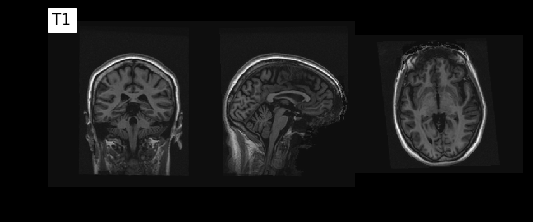

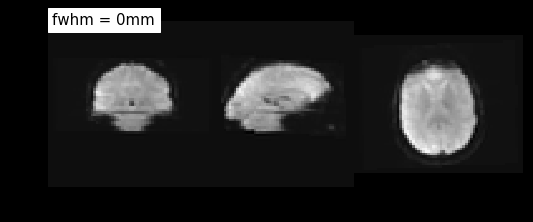

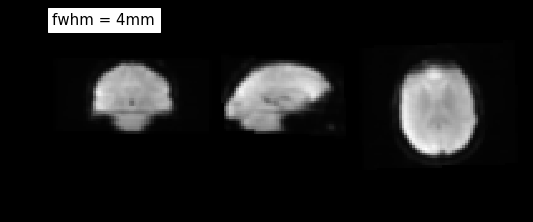

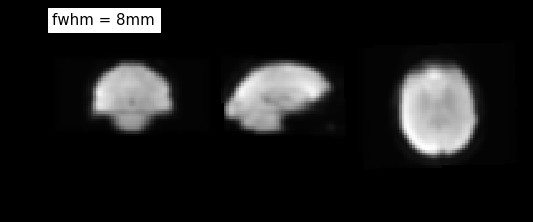

In [12]:
from nilearn import image, plotting
plotting.plot_epi(
    '/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

out_path = '/output/datasink/preproc/sub-01/task-fingerfootlips'
plotting.plot_epi(opj(out_path, 'sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray')

Now, let's investigate the motion parameters. How much did the subject move and turn in the scanner?

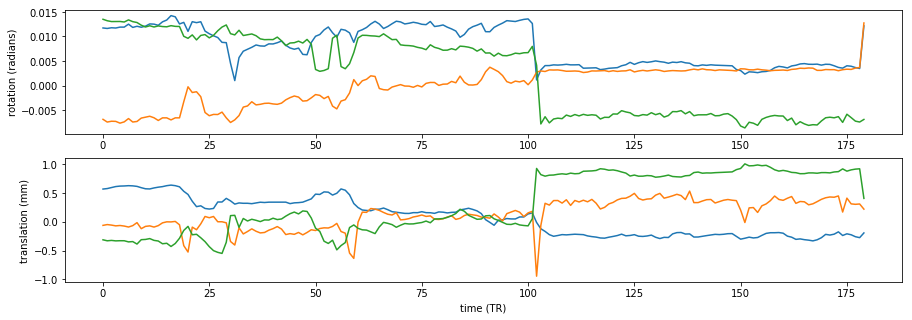

In [13]:
import numpy as np
import pylab as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_task-fingerfootlips_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)')

There seems to be a rather drastic motion around volume 102. Let's check if the outliers detection algorithm was able to pick this up.

Outliers were detected at volumes: [  59.  102.]


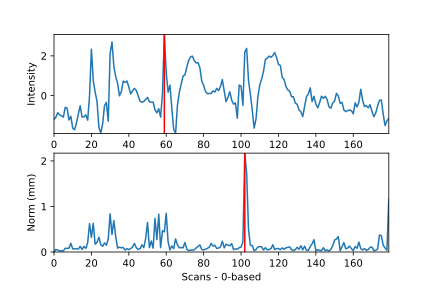

In [14]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-fingerfootlips/plot.sub-01_ses-test_task-fingerfootlips_bold.svg')